# 3D Structure Function Data with DYCOMS LES

This example will guide you through each step necessary to compute Longitudinal SFs from DYCOMS Data

$\textbf{General procedure}:$


    1 -  Load 3D DYCOMS dataset, dataset can be made available upon reasonable request
    2 -  Format dataset 
    3 -  Compute 3D longitudinal SF
    4 -  Plot 3D longitudinal SF
    5 -  Compute Isotropic SF
    6 -  Plot Isotropic SF

Note: To capture meaningful Structure functions in 3D, the vertical coordinate should  be stretched as 

$z^{*} = \int_{0}^{z} \frac{\overline{N}}{f} dz^{'}$ where N is derived from the 3D Brunt-Vaisala frequency and f is the Coriolis parameter

In [158]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm, Normalize
import matplotlib.ticker as ticker
import pyturbo_sf as psf
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt

linewidth = 2
fontsize = 12
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 2
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['savefig.dpi'] = 150
plt.rc('font', family='serif')
import gc

# Load Dataset

In [2]:
path = '/glade/derecho/scratch/aayouche/LES/outputs/'
ds_u = xr.open_zarr(path+'u_dycoms.zarr')
ds_v = xr.open_zarr(path+'v_dycoms.zarr')
ds_w = xr.open_zarr(path+'w_dycoms.zarr')
ds_b = xr.open_zarr(path+'buoyancy_dycoms.zarr')
xt = ds_u.x + ds_u.x.max()
yt = ds_u.y + ds_u.y.max()
zt = ds_v.z
N = (xr.apply_ufunc(np.abs,ds_b.buoyancy.differentiate('z').transpose('z','y','x'),dask='parallelized')**0.5).mean(('y','x'))
f = 1.0e-4
u = ds_u['u'].transpose('z','y','x')
v = ds_v['v'].transpose('z','y','x')
w = ds_w['w'].transpose('z','y','x')
y_coord = yt.expand_dims({'z': len(zt), 'x': len(xt)}).transpose('z','y','x').drop_vars('y')
x_coord = xt.expand_dims({'z': len(zt), 'y': len(yt)}).transpose('z','y','x').drop_vars('x')


# Compute $Z^{\star}$

In [3]:


def calculate_stretched_coordinate_1D(z_coord, N_field, f_scalar, surface_at_top=True):
    """
    Calculate the stretched coordinate Z* = ∫(N/f)dz' between free surface (eta) and z
    Optimized for case where:
    - z_coord is 1D (varies only with depth)
    - N_field is 1D (varies only with depth)
    - f_scalar is a constant scalar value
    
    Parameters:
    -----------
    z_coord : xarray.DataArray
        The 1D z-coordinate array with dimension 'z'
    N_field : xarray.DataArray
        The 1D Brunt-Väisälä frequency array with dimension 'z'
    f_scalar : float or xarray.DataArray with single value
        The Coriolis parameter as a scalar
    surface_at_top : bool, optional
        If True, assumes the free surface (eta) is at z_coord[0]
        If False, assumes the free surface is at z_coord[-1]
        
    Returns:
    --------
    Z_star : xarray.DataArray
        The 1D stretched coordinate array with dimension 'z'
    """
    # Convert everything to numpy arrays for calculation
    z_values = z_coord.values
    N_values = N_field.values
    f_value = float(f_scalar)  # Ensure it's a scalar
    
    # Calculate N/f directly - no need for loops
    N_over_f = N_values / f_value
    
    # Create output array
    Z_star_values = np.zeros_like(z_values)
    
    # Determine surface index
    surface_idx = 0 if surface_at_top else len(z_values) - 1
    
    # For each depth level, integrate from surface to that depth
    for k in range(len(z_values)):
        if k == surface_idx:
            Z_star_values[k] = 0.0
        else:
            if surface_at_top:
                # Integrate downward from surface
                if k > surface_idx:
                    z_section = z_values[surface_idx:k+1]
                    Nf_section = N_over_f[surface_idx:k+1]
                    Z_star_values[k] = np.trapz(Nf_section, z_section)
                else:
                    z_section = z_values[k:surface_idx+1]
                    Nf_section = N_over_f[k:surface_idx+1]
                    Z_star_values[k] = -np.trapz(Nf_section, z_section)
            else:
                # Integrate upward from depth to surface
                if k < surface_idx:
                    z_section = z_values[k:surface_idx+1]
                    Nf_section = N_over_f[k:surface_idx+1]
                    Z_star_values[k] = np.trapz(Nf_section, z_section)
                else:
                    z_section = z_values[surface_idx:k+1]
                    Nf_section = N_over_f[surface_idx:k+1]
                    Z_star_values[k] = -np.trapz(Nf_section, z_section)
    
    # Create xarray DataArray with the same dimension and coordinates as z_coord
    Z_star = xr.DataArray(
        Z_star_values,
        dims=z_coord.dims,
        coords=z_coord.coords,
        attrs={'long_name': 'Stretched coordinate Z*', 
               'units': 'm',
               'description': 'Stretched coordinate Z* = ∫(N/f)dz\''}
    )
    
    return Z_star

# First compute the 1D stretched coordinate
Z_star_1D = calculate_stretched_coordinate_1D(
    z_coord=zt,  # Your 1D z-coordinate 
    N_field=N,        # Your 1D N profile
    f_scalar=f,       # Your scalar f value
    surface_at_top=True
)

z_coord = Z_star_1D.expand_dims({'y': len(yt), 'x': len(xt)}).transpose('z','y','x').drop_vars('z')


# Format Dataset

In [4]:
ds = xr.Dataset(
    data_vars={
        'u': u,  # These are DataArrays - correct usage
        'v': v,
        'w': w
    },
    coords={
        'z': z_coord,  # These are your coordinate DataArrays
        'y': y_coord,
        'x': x_coord
    }
)


In [160]:
ds

<xarray.Dataset> Size: 966GB
Dimensions:  (z: 1200, y: 4096, x: 4096)
Coordinates:
    x        (z, y, x) float64 161GB 0.0 1.25 2.5 ... 5.118e+03 5.119e+03
    y        (z, y, x) float64 161GB 0.0 0.0 0.0 ... 5.119e+03 5.119e+03
    z        (z, y, x) float64 161GB 0.0 0.0 0.0 ... 6.817e+04 6.817e+04
Data variables:
    u        (z, y, x) float64 161GB dask.array<chunksize=(75, 128, 128), meta=np.ndarray>
    v        (z, y, x) float64 161GB dask.array<chunksize=(75, 128, 128), meta=np.ndarray>
    w        (z, y, x) float64 161GB dask.array<chunksize=(75, 128, 128), meta=np.ndarray>

# Calculate 3D Longitudinal SF

In [13]:
bins = {
    'x': np.logspace(np.log10(1.25), np.log10(5.0e3), 14),
    'y': np.logspace(np.log10(1.25), np.log10(5.0e3), 14),
    'z': np.logspace(np.log10(320.), np.log10(60.0e3), 12),
}
sf_result = psf.bin_sf_3d(
    ds=ds,
    variables_names=["u","v","w"],
    order=2,
    bins=bins,
    fun='longitudinal',
    bootsize={'z':4,'y':16,'x':16},
    initial_nbootstrap=100,
    max_nbootstrap=200,
    step_nbootstrap=50,
    convergence_eps=1.0,
    n_jobs=128, # number of physical cores / change it to -1 if you want to use logical cores
)

Dimensions ['z', 'y', 'x'] are already in the expected order
Using bootsize: {'z': 4, 'y': 16, 'x': 16}
Bootstrappable dimensions: ['z', 'y', 'x']
All three dimensions ['z', 'y', 'x'] are bootstrappable. Available spacings: [1, 2, 4, 8, 16, 32, 64, 128, 256]

STARTING BIN_SF_3D WITH FUNCTION TYPE: longitudinal
Variables: ['u', 'v', 'w'], Order: 2
Bootstrap parameters: initial=100, max=200, step=50
Convergence threshold: 1.0
Bootstrappable dimensions: ['z', 'y', 'x'] (count: 3)

Bin dimensions: z=11, y=13, x=13
Total bins: 1859
Bin type for x: logarithmic
Bin type for y: logarithmic
Bin type for z: logarithmic
Available spacings: [1, 2, 4, 8, 16, 32, 64, 128, 256]

INITIAL BOOTSTRAP PHASE
  Processing spacing 1 with 11 bootstraps
  Processing spacing 2 with 11 bootstraps
  Processing spacing 4 with 11 bootstraps
  Processing spacing 8 with 11 bootstraps
  Processing spacing 16 with 11 bootstraps
  Processing spacing 32 with 11 bootstraps
  Processing spacing 64 with 11 bootstraps
  Proc

# Plot 3D Longitudinal SF

In [159]:
def plot_sf_3d_box_custom(
        sf_result,
        cmap='jet',
        vmin=0.0,
        vmax=1.0,
        figsize=(12, 10),
        log_color=False,
        log_axes=False,
        z_offset=10e3,
        y_offset=300,
        x_min=300,
        y_min=300,
        elev=30,
        azim=-45,
        corner_color='0.5',
        line_width=1.5,
        n_levels=60
    ):
    """
    Plot structure function in 3D with custom offsets and corner lines
    
    Parameters:
    -----------
    sf_result : xarray.Dataset
        The structure function result with 'sf' variable
    cmap : str, optional
        Colormap name (default: 'jet')
    vmin, vmax : float, optional
        Min/max values for colormap (default: 0.0, 1.0)
    figsize : tuple, optional
        Figure size (default: (12, 10))
    log_color : bool, optional
        Whether to use log scale for color (default: False)
    log_axes : bool, optional
        Whether to use log scales for axes (default: False)
    z_offset : float, optional
        Offset for the top face (default: 10e3)
    y_offset : float, optional
        Offset for the front face (default: 300)
    x_min : float, optional
        Minimum x value (default: 300)
    y_min : float, optional
        Minimum y value (default: 300)
    elev, azim : float, optional
        Elevation and azimuth for 3D view (default: 30, -45)
    corner_color : str, optional
        Color of corner lines (default: '0.5')
    line_width : float, optional
        Width of corner lines (default: 1.5)
    n_levels : int, optional
        Number of contour levels (default: 60)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    """
    # Extract data
    array = sf_result.sf
    
    # Get slices for the three faces of the cube
    z_cut = array.isel(z=-1).values  # Top face
    x_cut = array.isel(x=-1).values  # Right face
    y_cut = array.isel(y=-1).values  # Back face
    
    # Determine global min/max across all faces for consistent colormap
    if vmin is None or vmax is None:
        all_data = np.concatenate([z_cut.flatten(), x_cut.flatten(), y_cut.flatten()])
        
        if log_color:
            # Filter out zeros and negative values for log scale
            all_data = all_data[all_data > 0]
            data_min = all_data.min() if len(all_data) > 0 else 1e-10
            data_max = array.values.max()
        else:
            data_min = all_data.min()
            data_max = all_data.max()
            
        vmin = vmin if vmin is not None else data_min
        vmax = vmax if vmax is not None else data_max
    
    # Get coordinates
    xx = sf_result.x.values
    yy = sf_result.y.values
    zz = sf_result.z.values
    
    # Create figure
    fig = plt.figure(figsize=figsize, dpi=120)
    ax = fig.add_subplot(111, projection='3d')
    
    # Create norm for colormap
    if log_color:
        norm = LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = Normalize(vmin=vmin, vmax=vmax)
    
    # Create meshgrids for the three faces
    X, Y = np.meshgrid(xx, yy)
    Y_yz, Z_yz = np.meshgrid(yy, zz)
    X_xz, Z_xz = np.meshgrid(xx, zz)
    
    # Plot the three faces with custom offsets
    contour_kw = dict(
        levels=n_levels,
        cmap=cmap,
        norm=norm,
        antialiased=True,
        alpha=0.9,
        vmin=vmin,
        vmax=vmax
    )
    
    # Top face (xy plane at max z)
    cf1 = ax.contourf(X, Y, z_cut, zdir='z', offset=zz[-1], **contour_kw)
    
    # Right face (yz plane at max x)
    cf2 = ax.contourf(x_cut, Y_yz, Z_yz, zdir='x', offset=xx[-1], **contour_kw)
    
    # Front face (xz plane at custom y offset)
    cf3 = ax.contourf(X_xz, y_cut, Z_xz, zdir='y', offset=y_offset, **contour_kw)
    
    # Set custom axis limits
    ax.set_zlim(10e3+2000, zz[-1])
    ax.set_xlim(x_min, xx[-1])
    ax.set_ylim(y_min, yy[-1])
    
    # Apply log scale if requested
    if log_axes:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_zscale('log')
    
    # Get the actual limits for the box
    x_low, x_high = ax.get_xlim()
    y_low, y_high = ax.get_ylim()
    z_low, z_high = ax.get_zlim()
    
    # Now explicitly draw all corner lines using the exact limits
    
    # Bottom edges (z=z_low)
    ax.plot([x_low, x_high], [y_low, y_low], [z_low, z_low], corner_color, linewidth=line_width, zorder=1e4)
    ax.plot([x_low, x_low], [y_low, y_high], [z_low, z_low], corner_color, linewidth=line_width, zorder=1e4)
    ax.plot([x_high, x_high], [y_low, y_high], [z_low, z_low], corner_color, linewidth=line_width, zorder=1e4)
    ax.plot([x_low, x_high], [y_high, y_high], [z_low, z_low], corner_color, linewidth=line_width, zorder=1e4)
    
    # Vertical edges
    ax.plot([x_low, x_low], [y_low, y_low], [z_low, z_high], corner_color, linewidth=line_width, zorder=1e4)
    ax.plot([x_high, x_high], [y_low, y_low], [z_low, z_high], corner_color, linewidth=line_width, zorder=1e4)
    ax.plot([x_low, x_low], [y_high, y_high], [z_low, z_high], corner_color, linewidth=line_width, zorder=1e4)
    ax.plot([x_high, x_high], [y_high, y_high], [z_low, z_high], corner_color, linewidth=line_width, zorder=1e4)
    
    # Top edges (z=z_high)
    ax.plot([x_low, x_high], [y_low, y_low], [z_high, z_high], corner_color, linewidth=line_width, zorder=1e4)
    ax.plot([x_low, x_low], [y_low, y_high], [z_high, z_high], corner_color, linewidth=line_width, zorder=1e4)
    ax.plot([x_high, x_high], [y_low, y_high], [z_high, z_high], corner_color, linewidth=line_width, zorder=1e4)
    ax.plot([x_low, x_high], [y_high, y_high], [z_high, z_high], corner_color, linewidth=line_width, zorder=1e4)
    
    # Set labels
    ax.set_xlabel(r'$r_x$ [m]', fontsize=12)
    ax.set_ylabel(r'$r_y$ [m]', fontsize=12)
    ax.set_zlabel(r'$r_z^{\star}$ [m]', fontsize=12)
    
    # Set view angle
    ax.view_init(elev=elev, azim=azim)
    
    # Add colorbar using the last contourf object
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(cf3, cax=cbar_ax)
    
    # Format the colorbar ticks for log scale
    if log_color:
        import matplotlib.ticker as ticker
        cbar.ax.yaxis.set_major_formatter(ticker.LogFormatterSciNotation(base=10.0))
    
    # Add colorbar label
    if hasattr(sf_result, 'attrs') and 'long_name' in sf_result.attrs:
        cbar.set_label(sf_result.attrs['long_name'], fontsize=12)
    else:
        cbar.set_label(r'$\delta u_{LL}~[m^{2}~s^{-2}]$', fontsize=12)
    
    # Set aspect ratio
    ax.set_box_aspect([1, 1, 0.7])
    
    # Remove grid lines for cleaner look
    ax.grid(False)
    
    # Improve overall layout
    fig.tight_layout(rect=[0, 0, 0.85, 1])
    
    return fig

/glade/derecho/scratch/aayouche/tmp/ipykernel_127373/1519335620.py:193: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.85, 1])


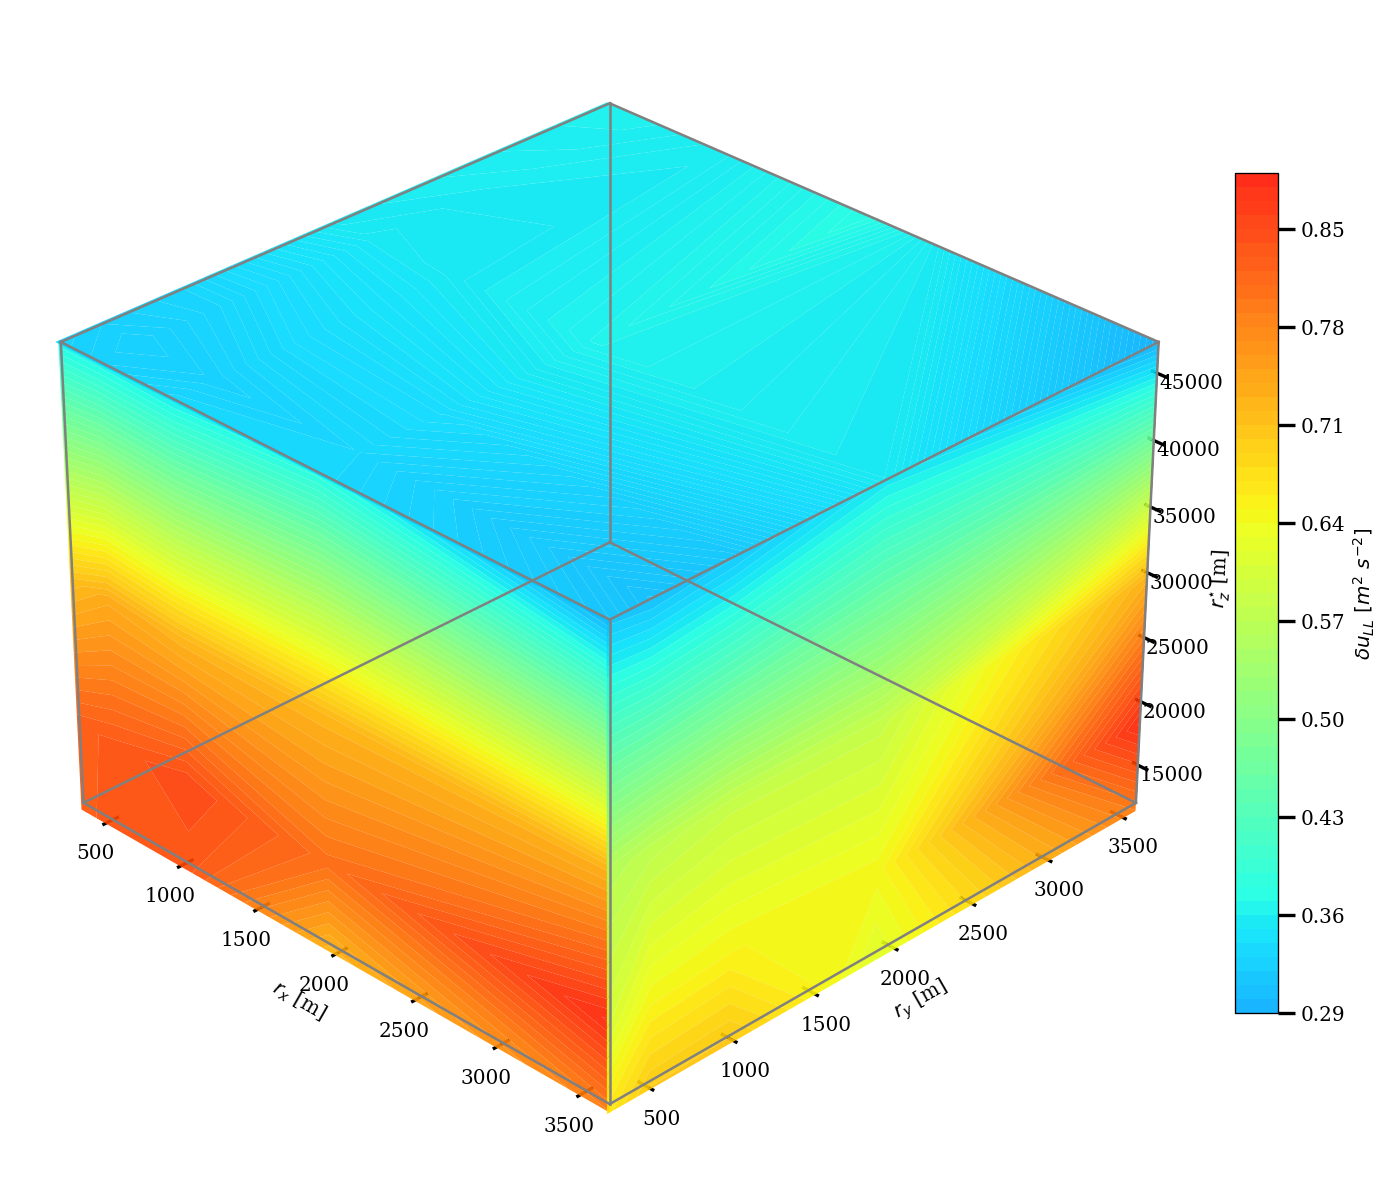

In [157]:
fig = plot_sf_3d_box_custom(sf_result)